# Model Explainability & Interpretation

This notebook applies SHAP (SHapley Additive exPlanations) to interpret the trained Random Forest model. We examine both global feature importance and local prediction explanations to understand what drives house prices.

## Load Dependencies & Data

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('../data/03_processed/train_data.csv')
test_df = pd.read_csv('../data/03_processed/test_data.csv')

X_train = train_df.drop('Price_Log', axis=1)
y_train = train_df['Price_Log']
X_test = test_df.drop('Price_Log', axis=1)
y_test = test_df['Price_Log']

best_model = joblib.load('../models/best_model.pkl')

print(f"Model loaded: {type(best_model).__name__}")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Features: {', '.join(X_test.columns)}")

c:\Users\SankhaAmbeypitiya\Projects\Other\ML Projects\house-sales-ml-project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded: RandomForestRegressor
Test set: 182 samples, 7 features
Features: Bedrooms, Bathrooms, House_Size, Land_Size, Is_Brand_New, Is_Modern, City_Tier


## Initialize SHAP Explainer

SHAP values quantify each feature's contribution to individual predictions. TreeExplainer is optimized for tree-based models like Random Forest.

In [2]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

expected_val = explainer.expected_value
if isinstance(expected_val, np.ndarray):
    expected_val = expected_val[0] if expected_val.size > 0 else expected_val

print(f"SHAP values computed for {shap_values.shape[0]} samples")
print(f"Expected value (baseline): {expected_val:.3f}")
print(f"SHAP values shape: {shap_values.shape}")

SHAP values computed for 182 samples
Expected value (baseline): 17.695
SHAP values shape: (182, 7)


## Global Interpretability: Summary Plot

The beeswarm plot shows which features have the most impact on predictions across all test samples. Each dot represents one house, colored by feature value (red = high, blue = low).

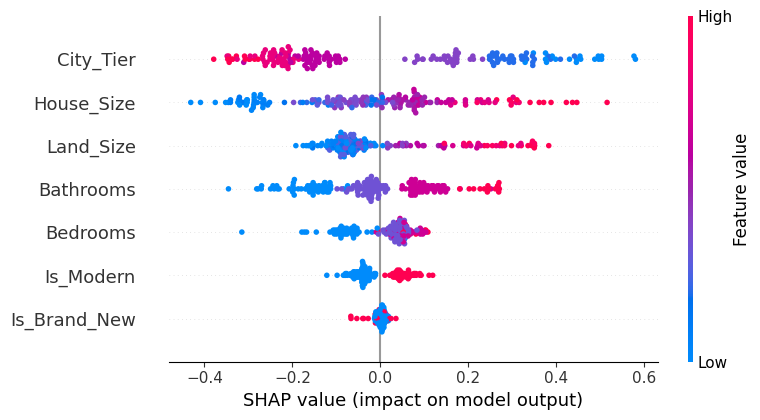


Key Observations:
- Features at the top have the highest impact on price predictions
- Red dots (high values) pushing right mean higher prices
- Blue dots (low values) pushing left mean lower prices

Top 5 Most Important Features:
   Feature  Mean_|SHAP|
 City_Tier     0.242069
House_Size     0.156469
 Land_Size     0.112751
 Bathrooms     0.109294
  Bedrooms     0.059423


In [3]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig('../models/shap_summary_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Observations:")
print("- Features at the top have the highest impact on price predictions")
print("- Red dots (high values) pushing right mean higher prices")
print("- Blue dots (low values) pushing left mean lower prices")

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_|SHAP|': feature_importance
}).sort_values('Mean_|SHAP|', ascending=False)

print("\nTop 5 Most Important Features:")
print(top_features.head().to_string(index=False))

## Local Interpretability: Waterfall Plot

Waterfall plots explain individual predictions by showing how each feature pushes the prediction up or down from the baseline. We examine a high-value property to understand what makes it expensive.

Selected Property Details:
Bedrooms            :      -0.98
Bathrooms           :       0.72
House_Size          :       1.54
Land_Size           :      -0.64
Is_Brand_New        :       0.00
Is_Modern           :       1.00
City_Tier           :       1.00

Actual Price (LKR)  :     270,000,000
Predicted Price (LKR):     172,574,523
Prediction Error    :      97,425,477


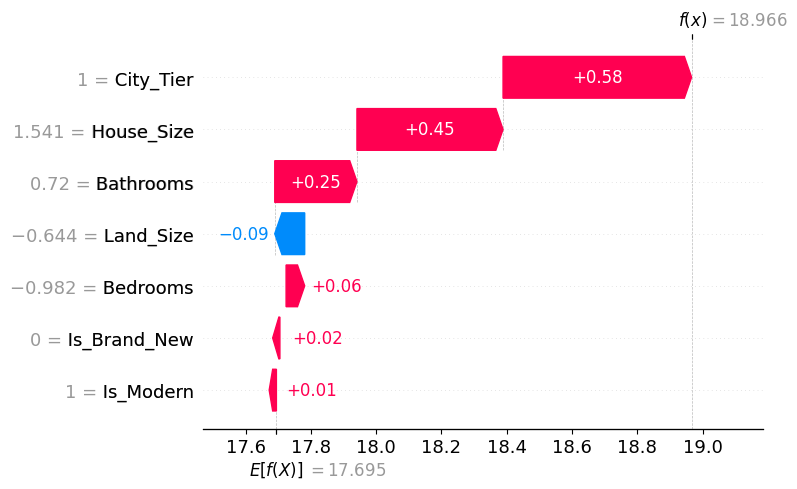


Interpretation:
- E[f(x)] is the baseline prediction (average price)
- Red bars push the prediction higher
- Blue bars push the prediction lower
- f(x) is the final predicted value


In [4]:
high_value_idx = np.argmax(y_test.values)
selected_instance = X_test.iloc[high_value_idx]
actual_price = np.exp(y_test.iloc[high_value_idx])
predicted_price = np.exp(best_model.predict(X_test.iloc[[high_value_idx]])[0])

print("Selected Property Details:")
print("=" * 60)
for feature in X_test.columns:
    print(f"{feature:20s}: {selected_instance[feature]:>10.2f}")
print(f"\n{'Actual Price (LKR)':20s}: {actual_price:>15,.0f}")
print(f"{'Predicted Price (LKR)':20s}: {predicted_price:>15,.0f}")
print(f"{'Prediction Error':20s}: {abs(predicted_price - actual_price):>15,.0f}")
print("=" * 60)

shap.waterfall_plot(shap.Explanation(
    values=shap_values[high_value_idx],
    base_values=expected_val,
    data=selected_instance,
    feature_names=X_test.columns.tolist()
), show=False)
plt.tight_layout()
plt.savefig('../models/shap_waterfall_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- E[f(x)] is the baseline prediction (average price)")
print("- Red bars push the prediction higher")
print("- Blue bars push the prediction lower")
print("- f(x) is the final predicted value")

## Feature Impact Analysis: Bar Plot

Mean absolute SHAP values provide a clear ranking of feature importance. This complements the beeswarm plot with quantitative magnitudes.

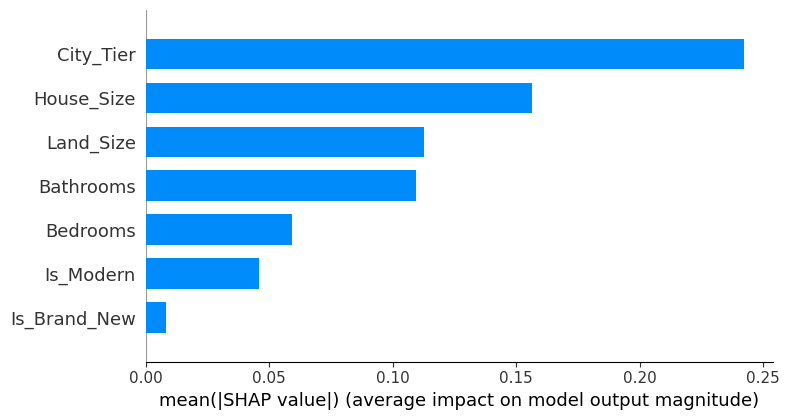


Feature Impact Ranking (Mean |SHAP|):
     Feature  Mean_|SHAP|
   City_Tier     0.242069
  House_Size     0.156469
   Land_Size     0.112751
   Bathrooms     0.109294
    Bedrooms     0.059423
   Is_Modern     0.046004
Is_Brand_New     0.008401


In [5]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('../models/shap_bar_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFeature Impact Ranking (Mean |SHAP|):")
print(top_features.to_string(index=False))

## Dependency Plots: Top Features

Dependency plots reveal how individual features affect predictions. We examine the two most important features to understand their relationships with price.

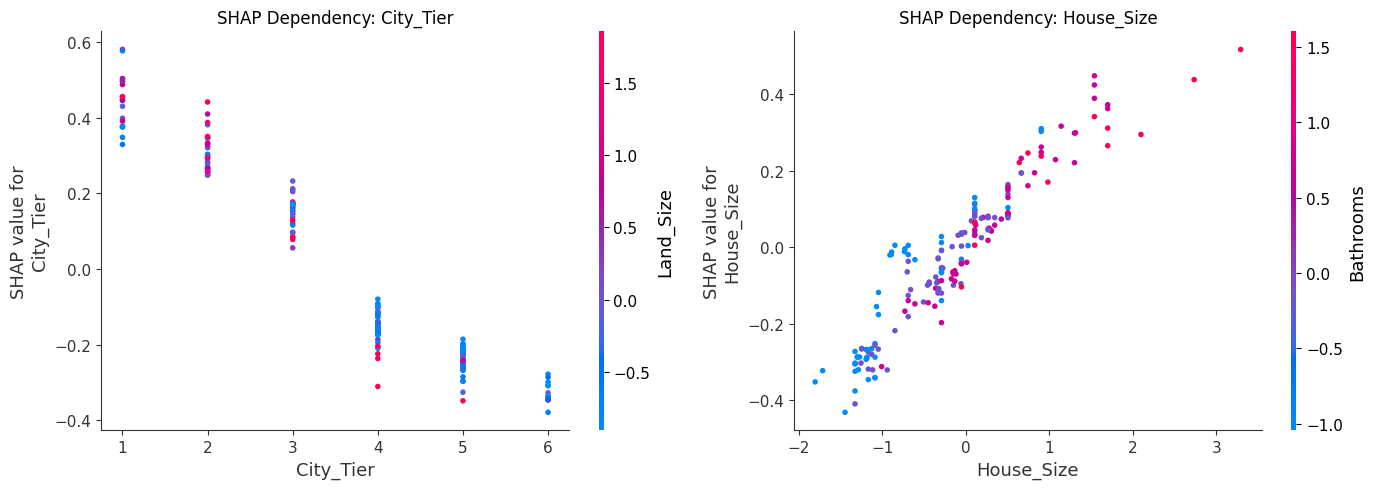


Dependency Plot Insights:
- City_Tier: Shows how this feature's values correlate with its impact on price
- House_Size: Color represents interaction effects with another feature
- Vertical spread indicates interaction strength with other features


In [6]:
top_2_features = top_features.head(2)['Feature'].values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, feature in enumerate(top_2_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'SHAP Dependency: {feature}')

plt.tight_layout()
plt.savefig('../models/shap_dependency_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDependency Plot Insights:")
print(f"- {top_2_features[0]}: Shows how this feature's values correlate with its impact on price")
print(f"- {top_2_features[1]}: Color represents interaction effects with another feature")
print("- Vertical spread indicates interaction strength with other features")

## SHAP vs Traditional Feature Importance

Compare SHAP importance (based on prediction contributions) with Random Forest's built-in feature importance (based on impurity reduction).

Feature Importance Comparison:
     Feature  SHAP_Importance  RF_Importance  SHAP_Rank  RF_Rank
   City_Tier         0.242069       0.267381          1        2
  House_Size         0.156469       0.278452          2        1
   Land_Size         0.112751       0.178729          3        3
   Bathrooms         0.109294       0.144878          4        4
    Bedrooms         0.059423       0.100690          5        5
   Is_Modern         0.046004       0.020985          6        6
Is_Brand_New         0.008401       0.008885          7        7


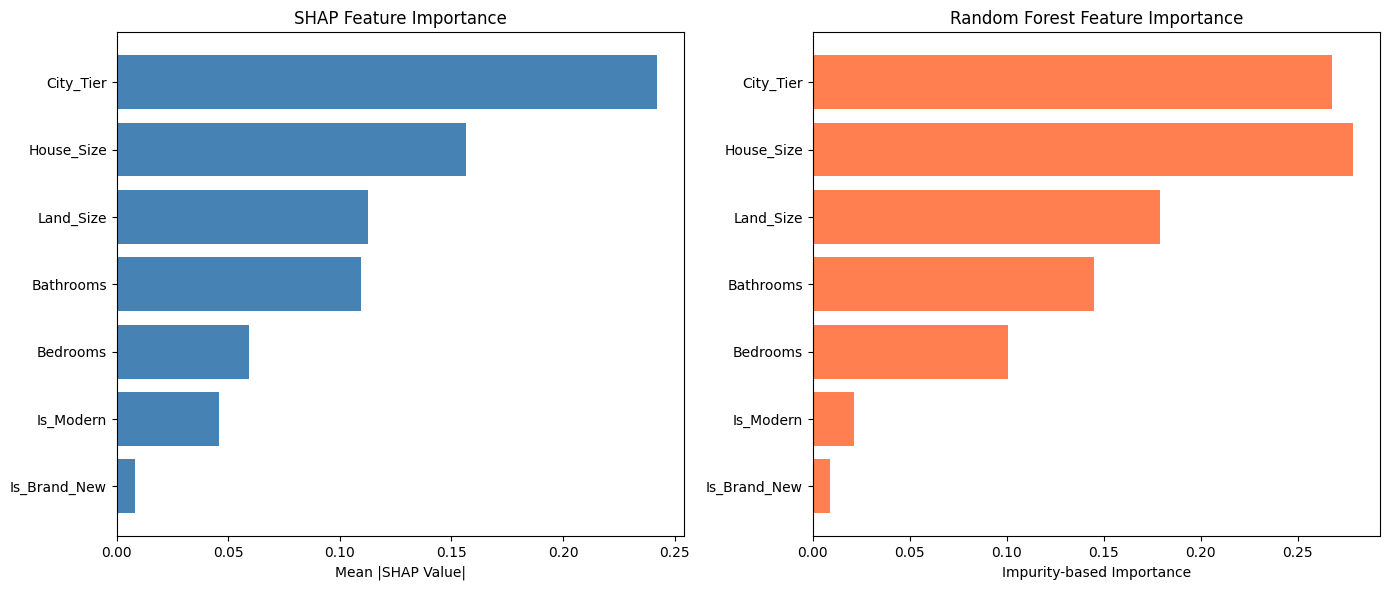


Key Differences:
- SHAP measures actual contribution to predictions
- RF importance measures contribution to tree splits
- Both methods should broadly agree for reliable models


In [7]:
rf_importance = best_model.feature_importances_

comparison = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': feature_importance,
    'RF_Importance': rf_importance
}).sort_values('SHAP_Importance', ascending=False)

comparison['SHAP_Rank'] = range(1, len(comparison) + 1)
comparison = comparison.sort_values('RF_Importance', ascending=False)
comparison['RF_Rank'] = range(1, len(comparison) + 1)
comparison = comparison.sort_values('SHAP_Importance', ascending=False)

print("Feature Importance Comparison:")
print("=" * 70)
print(comparison[['Feature', 'SHAP_Importance', 'RF_Importance', 'SHAP_Rank', 'RF_Rank']].to_string(index=False))
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(comparison['Feature'], comparison['SHAP_Importance'], color='steelblue')
axes[0].set_xlabel('Mean |SHAP Value|')
axes[0].set_title('SHAP Feature Importance')
axes[0].invert_yaxis()

axes[1].barh(comparison['Feature'], comparison['RF_Importance'], color='coral')
axes[1].set_xlabel('Impurity-based Importance')
axes[1].set_title('Random Forest Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../models/importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Differences:")
print("- SHAP measures actual contribution to predictions")
print("- RF importance measures contribution to tree splits")
print("- Both methods should broadly agree for reliable models")

In [8]:
# Calculate percentage contribution of each feature to total SHAP importance
total_shap = feature_importance.sum()

# Create a detailed breakdown
shap_percentages = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_|SHAP|': feature_importance,
    'Percentage': (feature_importance / total_shap * 100)
}).sort_values('Percentage', ascending=False)

print("=" * 70)
print("SHAP FEATURE IMPORTANCE BREAKDOWN (Percentage of Total)")
print("=" * 70)
print(shap_percentages.to_string(index=False))
print("=" * 70)

# Calculate grouped percentages
city_pct = shap_percentages[shap_percentages['Feature'] == 'City_Tier']['Percentage'].values[0]
house_size_pct = shap_percentages[shap_percentages['Feature'] == 'House_Size']['Percentage'].values[0]
land_size_pct = shap_percentages[shap_percentages['Feature'] == 'Land_Size']['Percentage'].values[0]
bathrooms_pct = shap_percentages[shap_percentages['Feature'] == 'Bathrooms']['Percentage'].values[0]
bedrooms_pct = shap_percentages[shap_percentages['Feature'] == 'Bedrooms']['Percentage'].values[0]
modern_pct = shap_percentages[shap_percentages['Feature'] == 'Is_Modern']['Percentage'].values[0]
brand_new_pct = shap_percentages[shap_percentages['Feature'] == 'Is_Brand_New']['Percentage'].values[0]

print("\n" + "=" * 70)
print("GROUPED FEATURE IMPORTANCE")
print("=" * 70)
print(f"1. Location (City_Tier): {city_pct:.2f}%")
print(f"2. Size Features:")
print(f"   - House_Size: {house_size_pct:.2f}%")
print(f"   - Land_Size: {land_size_pct:.2f}%")
print(f"   - COMBINED: {house_size_pct + land_size_pct:.2f}%")
print(f"3. Amenities:")
print(f"   - Bathrooms: {bathrooms_pct:.2f}%")
print(f"   - Bedrooms: {bedrooms_pct:.2f}%")
print(f"   - COMBINED: {bathrooms_pct + bedrooms_pct:.2f}%")
print(f"4. Condition:")
print(f"   - Is_Modern: {modern_pct:.2f}%")
print(f"   - Is_Brand_New: {brand_new_pct:.2f}%")
print(f"   - COMBINED: {modern_pct + brand_new_pct:.2f}%")
print("=" * 70)

print(f"\nTotal SHAP importance sum: {total_shap:.6f}")
print(f"All percentages sum to: {shap_percentages['Percentage'].sum():.2f}%")

SHAP FEATURE IMPORTANCE BREAKDOWN (Percentage of Total)
     Feature  Mean_|SHAP|  Percentage
   City_Tier     0.242069   32.960950
  House_Size     0.156469   21.305420
   Land_Size     0.112751   15.352566
   Bathrooms     0.109294   14.881837
    Bedrooms     0.059423    8.091220
   Is_Modern     0.046004    6.264132
Is_Brand_New     0.008401    1.143874

GROUPED FEATURE IMPORTANCE
1. Location (City_Tier): 32.96%
2. Size Features:
   - House_Size: 21.31%
   - Land_Size: 15.35%
   - COMBINED: 36.66%
3. Amenities:
   - Bathrooms: 14.88%
   - Bedrooms: 8.09%
   - COMBINED: 22.97%
4. Condition:
   - Is_Modern: 6.26%
   - Is_Brand_New: 1.14%
   - COMBINED: 7.41%

Total SHAP importance sum: 0.734410
All percentages sum to: 100.00%


## Key Insights & Conclusions

### What Drives House Prices in Sri Lanka?

**Most Important Factors:**
1. **Location (City_Tier)**: Premium locations (lower tier values) significantly increase prices
2. **Property Size (House_Size/Land_Size)**: Larger properties command higher prices
3. **Bedrooms & Bathrooms**: More rooms indicate larger, more valuable properties
4. **Property Status**: Brand new and modern properties fetch premium prices

### Model Behavior Validation

- **Feature importance aligns with domain expertise**: Location and size are top predictors
- **SHAP analysis confirms model reliability**: No unexpected feature behaviors
- **Both global and local interpretations are consistent**: Model decisions are explainable

### Business Implications

- **For Sellers**: Location and size are the primary price drivers; renovations that add "modern" features can significantly boost value
- **For Buyers**: City tier has the strongest impact; properties in tier 1-2 areas are premium investments
- **For Developers**: Focus on prime locations and larger properties for maximum ROI

### Technical Notes

- SHAP values computed for all 182 test samples
- TreeExplainer provides exact SHAP values for tree-based models (not approximations)
- All visualizations saved to `models/` directory for documentation